In [ ]:
import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

path2 = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

df = pd.read_csv(os.path.join(path2, 'AEP_hourly.csv'))
df = df.rename(columns={'Datetime': 'timestamp', 'AEP_MW': 'load'})
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.dropna().sort_values('timestamp').reset_index(drop=True)

df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

final_data = df[['load', 'hour', 'day_of_week', 'month']].values

100%|██████████| 11.4M/11.4M [00:00<00:00, 106MB/s]

Extracting files...


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(final_data)

def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window, :])
        y.append(data[i + window, 0])
    return np.array(X), np.array(y)

window_size = 24
X, y = create_sequences(scaled_data, window_size)

# PJM/AEP has ~121,273 hours. 8 years is roughly 70,080 hours.
train_size = 70080
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.1)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - loss: 0.0284 - val_loss: 0.0027
Epoch 2/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 3/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 4/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0019 - val_loss: 9.2766e-04
Epoch 6/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 0.0016 - val_loss: 9.8272e-04
Epoch 7/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0013 - val_loss: 6.9750e-04
Epoch 8/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0012 - val_loss: 8.1293e-04
Epoch 9/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - loss: 0.0011 - val_loss: 5.0610e-04
Epoch 11/15
493/493 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 0.0010 - val_loss: 6.1065e-04
Epoch 

1600/1600 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
longterm MAE: 310.9607809095669
longterm RMSE: 379.9856298303511


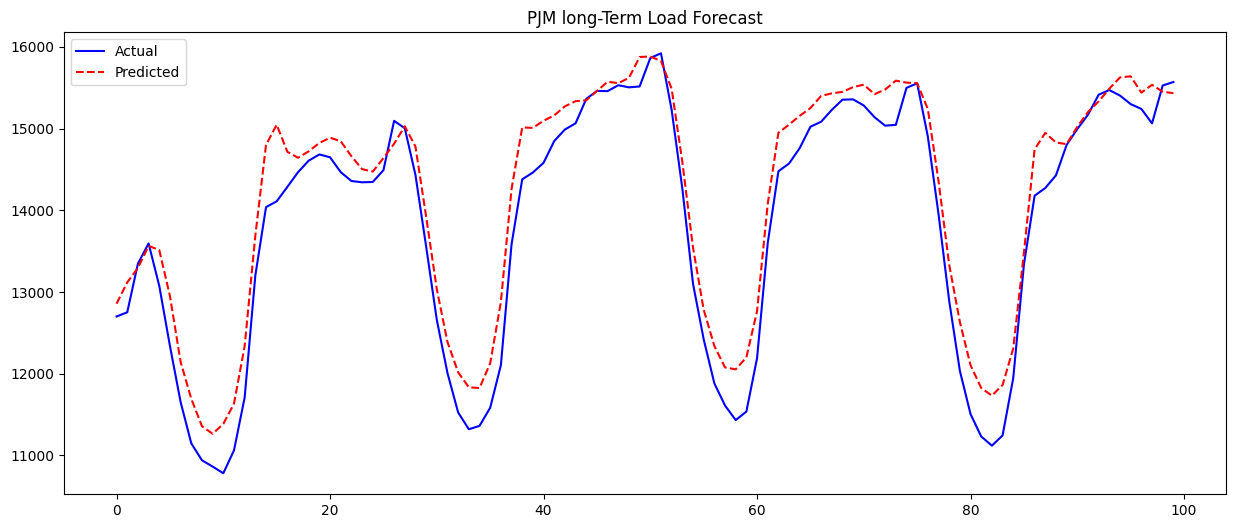

In [ ]:
predictions = model.predict(X_test)

pred_dummy = np.zeros((len(predictions), final_data.shape[1]))
pred_dummy[:, 0] = predictions.flatten()
predictions_unscaled = scaler.inverse_transform(pred_dummy)[:, 0]

actual_dummy = np.zeros((len(y_test), final_data.shape[1]))
actual_dummy[:, 0] = y_test
actual_unscaled = scaler.inverse_transform(actual_dummy)[:, 0]

mae = mean_absolute_error(actual_unscaled, predictions_unscaled)
rmse = np.sqrt(mean_squared_error(actual_unscaled, predictions_unscaled))

print(f"longterm MAE: {mae}")
print(f"longterm RMSE: {rmse}")

plt.figure(figsize=(15, 6))
plt.plot(actual_unscaled[:100], label='Actual', color='blue')
plt.plot(predictions_unscaled[:100], label='Predicted', color='red', linestyle='--')
plt.title('PJM long-Term Load Forecast')
plt.legend()
plt.show()

               Model         MAE
0  Linear Regression  142.364210
1      Random Forest  135.780595
2                KNN  565.258747
3      Decision Tree  193.893392
4               LSTM  310.960781


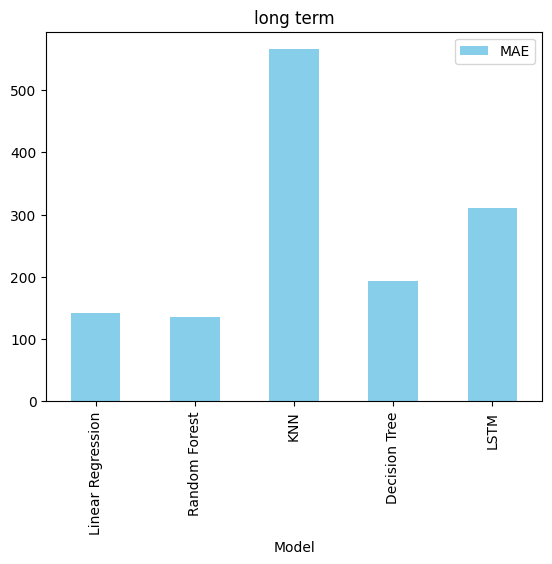

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

lr = LinearRegression().fit(X_train_flat, y_train)
rf = RandomForestRegressor(n_estimators=50, random_state=42).fit(X_train_flat, y_train)
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train_flat, y_train)
dt = DecisionTreeRegressor(random_state=42).fit(X_train_flat, y_train)

def get_mae(pred):
    dummy = np.zeros((len(pred), final_data.shape[1]))
    dummy[:, 0] = pred
    return mean_absolute_error(actual_unscaled, scaler.inverse_transform(dummy)[:, 0])

models = ['Linear Regression', 'Random Forest', 'KNN', 'Decision Tree', 'LSTM']
results = [get_mae(lr.predict(X_test_flat)), get_mae(rf.predict(X_test_flat)),
           get_mae(knn.predict(X_test_flat)), get_mae(dt.predict(X_test_flat)), mae]

performance_df = pd.DataFrame({'Model': models, 'MAE': results})
print(performance_df)

performance_df.plot(kind='bar', x='Model', y='MAE', color='skyblue')
plt.title('long term')
plt.show()